<a href="https://colab.research.google.com/github/alleyex/tensorflow_lab/blob/main/predicting_sunspots_with_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
def plot_series(x, y, format = '-' , start = 0, end = None, title = None, xlabel = None, ylabel = None, legend = None):
  """
  visualizes time series data

  Args:
    x (array of int): contains values for the x-axis
    y (array of int or tuple of arrays): contains values for the y-axis
    format (string): line style when plotting the graph
    start (int): first time step to plot
    end (int): last time step to plot
    title (string): title of the plot
    xlabel (string): label for the x-axis
    ylabel (string): label for the y-axis
    legend (list of strings): legend for the plot
  """

  # Setup dimensions of the graph figure
  plt.figure(figsize = (10, 6))

  # Check if there ara more than two series to plot
  if type(y) is tuple:

    # Look over the y elements
    for y_curr in y:

      # Plot the x and current y values
      plt.plot(x[start: end], y_curr[start: end], format)

  else:

    # Plot the x and current y values
    plt.plot(x[start: end], y[start: end], format)

  # Label the x-axis
  plt.xlabel(xlabel)

  # label the y-axis
  plt.ylabel(ylabel)

  # Set the title
  plt.title(title)

  # Set the legend
  if legend:
    plt.legend(legend)

  plt.grid(True)

  # Draw the graph on screen
  plt.show()


In [3]:
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2024-05-13 12:38:34--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.207, 173.194.211.207, 173.194.212.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2024-05-13 12:38:34 (46.4 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



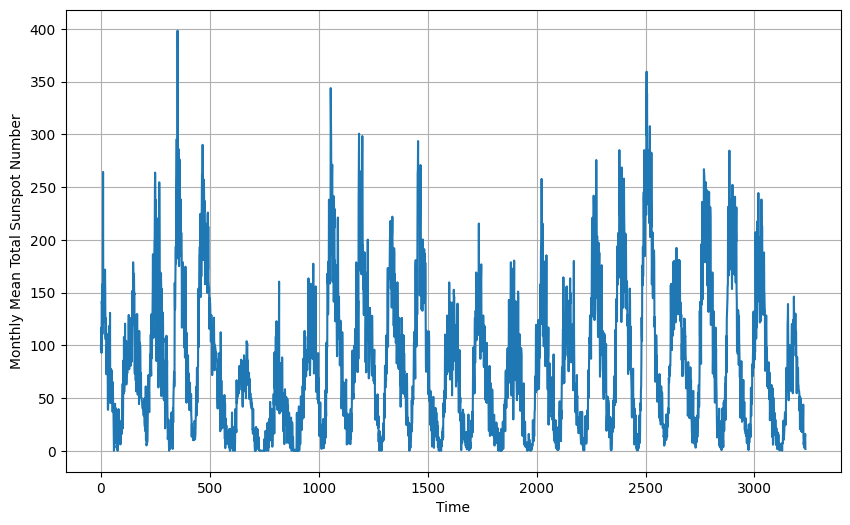

In [4]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:

  # Initialize reader
  reader = csv.reader(csvfile, delimiter = ',')

  # Skip the first line
  next(reader)

  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

  # Convert lists to numpy arrays
  time = np.array(time_step)
  series = np.array(sunspots)

  # Preview the data
  plot_series(time, series, xlabel = "Time", ylabel = "Monthly Mean Total Sunspot Number")


In [5]:
# Define the split time
split_time = 3000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
# Prepare Features and Labels
def windowed_dataset(series, wondow_size, batch_size, shuffle_buffer):
  """
  Generates dataset windows for training

  Args:
    series (array of int): contains values for the time series
    wondow_size (int): the number of time steps to include in the feature
    batch_size (int): the batch size
    shuffle_buffer (int): buffer size to use for shuffle method

  Returns:
    dataset (tf.data.Dataset): TF Dataset containing time windows
  """

  # Generate a TF Dataset from the series values
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Window the data but only take those with the specified size
  dataset = dataset.window(wondow_size + 1, shift = 1, drop_remainder = True)

  # Flatten the windows by putting its elements in a single batch
  dataset = dataset.flat_map(lambda window: window.batch(wondow_size + 1))

  # Create tuples of features and labels
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))

  # Shuffle the windows
  dataset = dataset.shuffle(shuffle_buffer)

  # Create batches of windows
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset


In [7]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


In [8]:
# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', padding = 'causal', input_shape = [window_size, 1]),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

In [9]:
# Get initial weights
init_weights = model.get_weights()

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum = 0.9)

# Set the training parameters
model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer)

# Train in model
history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])


(1e-08, 0.001, 0.0, 30.0)

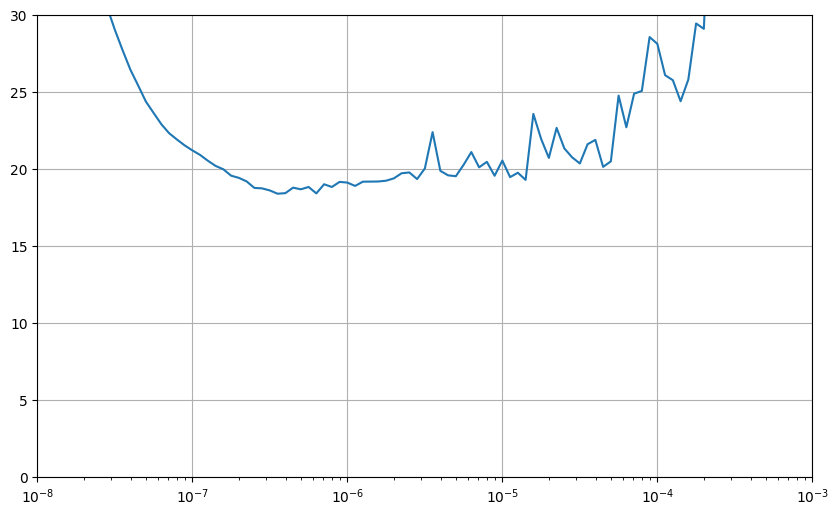

In [11]:
# Define the learning rate array
lrs = 1e-8 * 10**(np.arange(100) / 20)

# Set the figure size
plt.figure(figsize = (10, 6))

# Set the grid
plt.grid(True)

# plot the loss in log scale
plt.semilogx(lrs, history.history['loss'])

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])


In [12]:
# Reset states generated by keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [13]:
# Set the learning rate
learning_rate = 8e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)

# Set the training parameters
model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer, metrics = ['mae'])


In [ ]:
# Train the model
history = model.fit(train_set, epochs = 100)

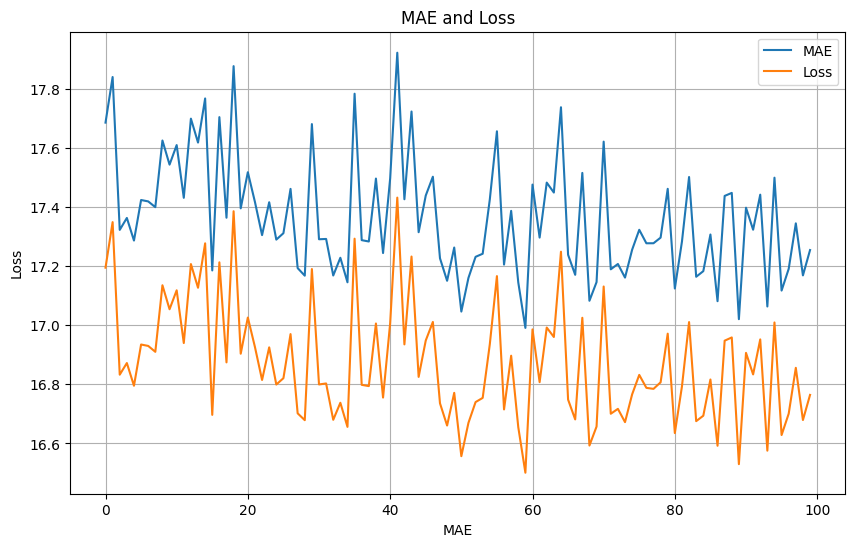

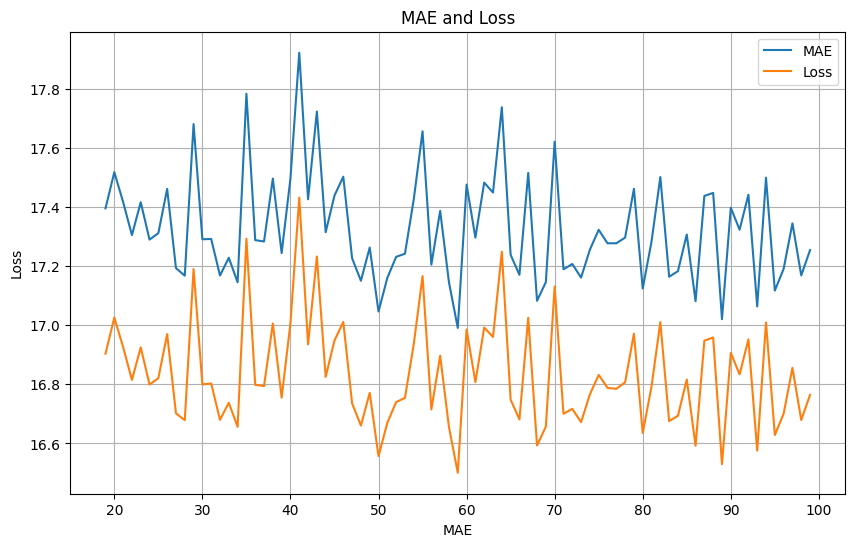

In [17]:
# Get mae and loss from history log
mae = history.history['mae']
loss = history.history['loss']

# Get number of epochs
epochs = range(len(loss))

# Plot mae and loss
plot_series(x = epochs, y = (mae, loss), title = "MAE and Loss", xlabel = "MAE", ylabel = "Loss", legend = ["MAE", "Loss"])

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(x = epochs_zoom, y = (mae_zoom, loss_zoom), title = "MAE and Loss", xlabel = "MAE", ylabel = "Loss", legend = ["MAE", "Loss"])



In [18]:
# Model Prediction
def model_forecast(model, series, widow_size, batch_size):
  """
  Uses an input model to generate predictions on data windows

  Args:
    model (tf.keras.Model): model that accepts data windows
    series (array of float): contains the values of the time series
    wondow_size (int): the number of time steps to include in the window
    batch_size (int): the batch size

  Returns:
    forecast (numpy array): array containing predictions
  """

  # Generate a TF Dataset from the series values
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Window the data but only take those with the specified size
  dataset = dataset.window(window_size, shift = 1, drop_remainder = True)

  # Flatten the windows by putting its elements in a single batch
  dataset = dataset.flat_map(lambda window: window.batch(window_size))

  # Create batches of windows
  dataset = dataset.batch(batch_size).prefetch(1)

  # Get predictions on the entire dataset
  forecast = model.predict(dataset)

  return forecast


8/8 [==============================] - 1s 15ms/step


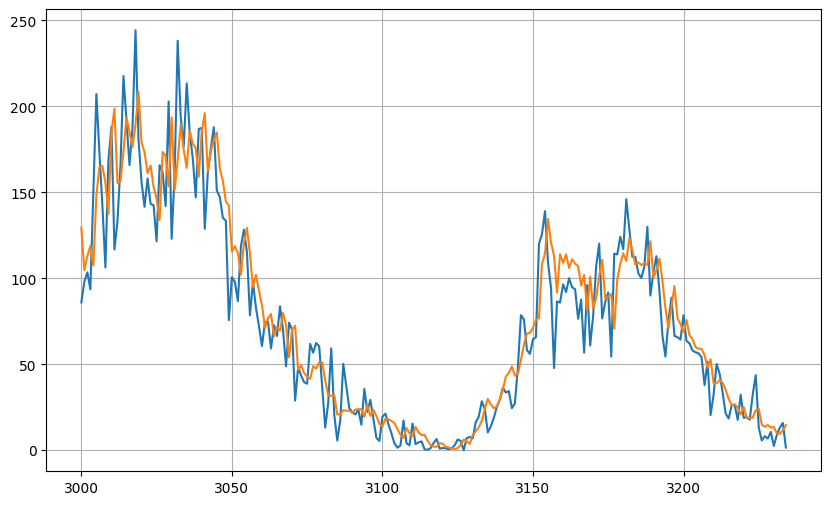

In [19]:
# Reduce the original series
forecast_series = series[split_time - window_size: -1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [20]:
# compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

14.887273


In [21]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-7,  momentum = 0.9)

# Set the training parameters
model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer, metrics = ['mae'])

# Train the model
history = model.fit(train_set, epochs = 10)

Epoch 1/10
93/93 [==============================] - 9s 42ms/step - loss: 16.3795 - mae: 16.8671
Epoch 2/10
93/93 [==============================] - 4s 39ms/step - loss: 16.3366 - mae: 16.8259
Epoch 3/10
93/93 [==============================] - 5s 53ms/step - loss: 16.2192 - mae: 16.7074
Epoch 4/10
93/93 [==============================] - 4s 41ms/step - loss: 16.2203 - mae: 16.7094
Epoch 5/10
93/93 [==============================] - 5s 52ms/step - loss: 16.2500 - mae: 16.7381
Epoch 6/10
93/93 [==============================] - 4s 39ms/step - loss: 16.2189 - mae: 16.7067
Epoch 7/10
93/93 [==============================] - 5s 49ms/step - loss: 16.2289 - mae: 16.7180
Epoch 8/10
93/93 [==============================] - 5s 45ms/step - loss: 16.2108 - mae: 16.6981
Epoch 9/10
93/93 [==============================] - 4s 37ms/step - loss: 16.2462 - mae: 16.7343
Epoch 10/10
93/93 [==============================] - 4s 39ms/step - loss: 16.2209 - mae: 16.7090


In [22]:
#  def decayed_learning_rate(step):
#  retrun initial_learning_rate * decay_rate ^ (step / decay_steps)

In [23]:
# Set the initial learning rate
initial_learning_rate = 1e-7

# Define the scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps = 400,
    decay_rate = 0.96,
    staircase = True
)

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate = lr_schedule, momentum = 0.9)

# Set the training parameters
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ['mae']
)

# Train the model
history = model.fit(train_set, epochs = 40)


Epoch 1/40
93/93 [==============================] - 9s 39ms/step - loss: 16.2240 - mae: 16.7118
Epoch 2/40
93/93 [==============================] - 4s 38ms/step - loss: 16.2065 - mae: 16.6924
Epoch 3/40
93/93 [==============================] - 6s 65ms/step - loss: 16.2093 - mae: 16.6959
Epoch 4/40
93/93 [==============================] - 4s 42ms/step - loss: 16.2183 - mae: 16.7060
Epoch 5/40
93/93 [==============================] - 4s 39ms/step - loss: 16.2320 - mae: 16.7215
Epoch 6/40
93/93 [==============================] - 4s 44ms/step - loss: 16.1938 - mae: 16.6822
Epoch 7/40
93/93 [==============================] - 4s 40ms/step - loss: 16.2264 - mae: 16.7148
Epoch 8/40
93/93 [==============================] - 4s 45ms/step - loss: 16.2510 - mae: 16.7393
Epoch 9/40
93/93 [==============================] - 6s 60ms/step - loss: 16.2387 - mae: 16.7270
Epoch 10/40
93/93 [==============================] - 4s 40ms/step - loss: 16.2070 - mae: 16.6934
Epoch 11/40
93/93 [====================

8/8 [==============================] - 2s 26ms/step


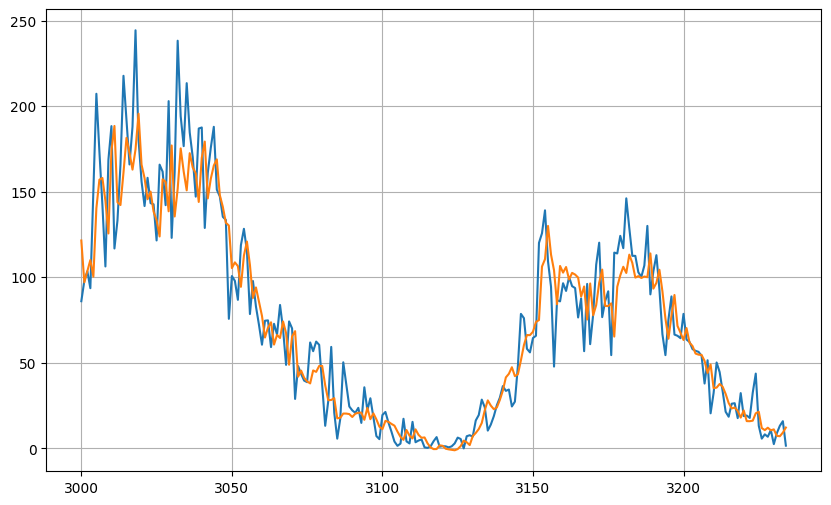

In [24]:
# Reduce the original series
forecast_series = series[split_time - window_size: -1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [25]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

14.312363
